## The Context

Australia has adopted an isolationist policy in response to the global coronavirus pandemic. Upon arriving in Australia, passengers are isolated in designated hotels for at least 14 days. While this process is highly effective, leaks can and do occur. Fortunately, these are regularly brought under control with effective contact tracing.

There is much discussion about the effectiveness of different state systems for hotel quarantine, and it would be an interesting problem to model using Bayesian Analysis. Fortunately, there have been only a handful of leaks during processing of more than 100,000 people. As part of this modelling, I want to find the underlying leak probability for each processed person. We can estimate this probability independently for each state and use it to understand if there are any fundamental differences.


## The Data
To keep things simple, I'm defining "leak" as COVID spreading unintendedly. IE, to a staff member in the system, or someone being separately isolated.

Based on some quick perusing of ABC news, I've formed a rough list of 13 separate leaks from hotel quarantine. 

NSW:
* Marriott Hotel at Circular Quay - August 2020
* Northern Beaches - December 2020
* Cleaner - December 2020
* Berala BWS - December 2020
* Bus Driver - December 2020
* Sofitel - February 2021 (Not yet confirmed to be a leak, but included for conservatism).


Victoria:
* Rydges on Swanston - May 2020
* Stamford Plaza - June 2020
* Park Royal hotel - January 2021
* Grand Hyatt - February 2021
* Holiday Inn - February 2021

And one each in:
* SA
* QLD
* WA



I've formed an estimate for the number of people who passed through the hotel quarantine system from the [ABS](https://www.abs.gov.au/statistics/industry/tourism-and-transport/overseas-arrivals-and-departures-australia).

I'm glad to re-run the numbers if you have more accurate figures for either leaks or arrivals.


| State | Arrivals |
|-------|----------|
| NSW   | 91,400   |
| VIC   | 26,710   |
| QLD   | 23,830   |
| SA    | 5,510    |
| WA    | 16,740   |


One argument is that there isn't enough data to compare the states or that certain states have been "lucky" or "unlucky". Using Bayesian Analysis, we can understand how confident we can be in our estimates of our underlying parameters (probability of a leak per person processed).


## The Model
Let's get started modelling by first importing what we need:

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams["figure.figsize"] = (20,20)
from warnings import filterwarnings
filterwarnings('ignore')

We can build a simple but effective model by treating the number of leaks as a *binomial* variable.

We can then infer the probability each processed person results in a leak based on the number of people processed and the number of leaks observed.

We need to provide a prior estimate for the probability of processing any one person resulting in a leak. 1% of people returning have covid, and 1% of them will result in a leak, for a *probability of leak* of 0.0001. However, I will use a very broad, non-informative prior estimate that is uniform between 0 and 1.

In [2]:
with pm.Model() as model: 
    #Set up our model
    states = ['NSW', 'VIC', 'QLD', 'SA', 'WA']
    number_of_people_processed = [91400, 26710, 23830, 5510, 16740]
    number_of_leaks_observed = [6, 5, 1, 1, 1]
    prob_of_leak = pm.Uniform('prob_of_leak',lower=0, upper=1, shape=5)  
    number_of_leaks = pm.Binomial('number_of_leaks', n = number_of_people_processed, p = prob_of_leak, observed = number_of_leaks_observed)

Now we can use *Markov Chain Monte Carlo* (MCMC) to find the distribution of the underlying parameter (*p*). We are trying to find the distribution of values for *p*, where it "makes sense", given the data we have observed and our prior estimate.

In [3]:
num_chains = 2
num_samples = 1_000
with model: 
    trace = pm.sample(draws=num_samples,chains = num_chains, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [prob_of_leak]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 11 seconds.


The beauty of MCMC is that instead of giving us a point estimate for each parameter, we get a probability distribution, representing how confident we can be in each value. This means we can be more confident in our comparisons between different parameters.

Let's visualise these distributions as boxplots using [Seaborn](https://seaborn.pydata.org/index.html). 


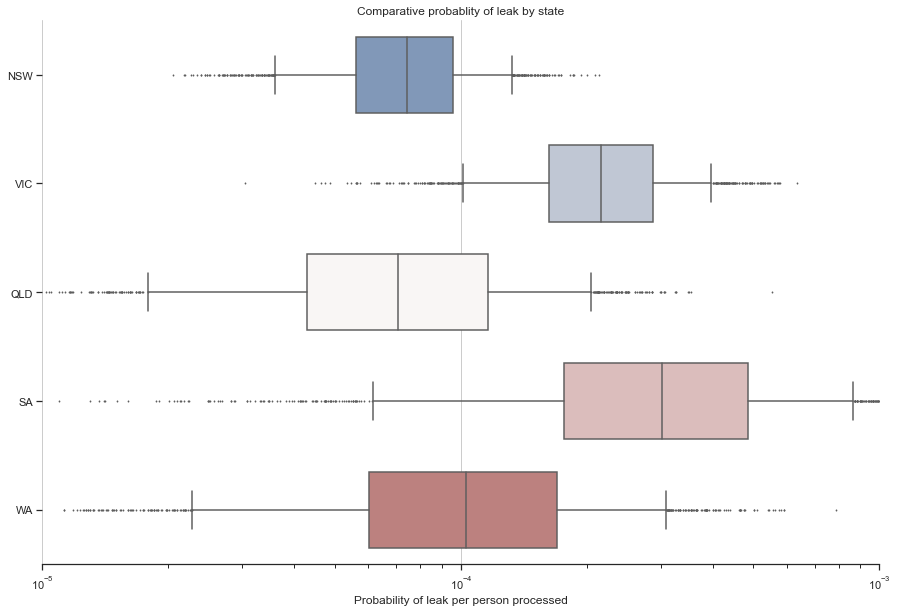

In [4]:
#Create a pandas dataframe.
state_col = []
prob_of_leak_col = []
for i in range(0,5):
    state = states[i]
    prob_of_leak = trace.prob_of_leak[:,i]
    state_col += num_chains*num_samples*[state]
    prob_of_leak_col += list(prob_of_leak)
    
data = {'State':state_col,'prob_of_leak':prob_of_leak_col}
df =  pd.DataFrame.from_dict(data)


#Visualise the data.
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(15, 10))

ax.set_xscale("log")

sns.boxplot(x="prob_of_leak", y="State", data=df, whis=[5, 95], width=0.7,
            palette="vlag", flierprops = dict(markerfacecolor = '0.50', markersize = 1))


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="Probability of leak per person processed")
ax.set_xlim(10**-5,10**-3)
ax.set(title="Comparative probablity of leak by state")

sns.despine(trim=True, left=True)

## Conclusion
We can see that there are two clusters of states.

* NSW, QLD and WA all have rates of leakage below 1 in 10,000
* VIC and SA, where the rate is 2-3 times higher.

NSW, in particular, has a relative risk of approximately 2.9 times lower than VIC.

Using Bayesian Analysis, we can be confident that there might be underlying differences in the effectiveness of different hotel quarantine programmes. We could use this to learn from those representing the *Gold Standard*.